In [1]:
write = True # log this version as new
MODEL_DESCRIPTION = "Use MAE"

In [2]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sys import stdout
from datetime import datetime
import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
import tensorflow_probability as tfp
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.nn import leaky_relu
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

In [4]:
LATENT_DIM = 128
BASE_DEPTH = 8
IMAGE_SHAPE = (5, 127, 127)
EPOCHS = 200
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-5
# Good value: 1e-6

In [5]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
now = datetime.now()

DATASET_NAME = "HSC_v6_small"
MODEL_TYPE = "VAE"
MODEL_VERSION = "v1.0"
MODEL_SUBVERSION = "v1.0." + now.strftime("%Y%m%d_%H_%M_%S")

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
model_path = os.path.join('/models', model_id, MODEL_SUBVERSION, 'model')
checkpoints_path = os.path.join('/models', model_id, MODEL_SUBVERSION, 'checkpoints')
logs_path = os.path.join('/logs', model_id, MODEL_SUBVERSION)
predictions_path = os.path.join('/predictions', model_id, MODEL_SUBVERSION)
weights_path = model_path + '/weights.h5'

os.makedirs(model_path, exist_ok = True)
os.makedirs(checkpoints_path, exist_ok = True)
os.makedirs(logs_path, exist_ok = True)
os.makedirs(predictions_path, exist_ok = True)

if write == True:
    with open("/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - " + MODEL_DESCRIPTION + " - B. Li" + "\n")
else:
    with open("/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - ... "+ " - B. Li" + "\n")

In [7]:
hf_train = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_training_small.hdf5', 'r')
hf_test = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing_small.hdf5', 'r')
hf_validation = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_validation_small.hdf5', 'r')
x_train = np.asarray(hf_train['image'][0:])
x_test = np.asarray(hf_test['image'][0:])
x_validation = np.asarray(hf_validation['image'][0:])
max_value = 4.16
x_train = np.true_divide(x_train, max_value)
x_test = np.true_divide(x_test, max_value)
x_validation = np.true_divide(x_validation, max_value)
y_train = np.asarray(hf_train['specz_redshift'][0:])[..., None]
y_test = np.asarray(hf_test['specz_redshift'][0:])[..., None]
y_validation = np.asarray(hf_validation['specz_redshift'][0:])[..., None]
# object_id_train = np.asarray(hf_train['object_id'][0:])
# object_id = np.asarray(hf_test['object_id'][0:])
# object_id_validation = np.asarray(hf_validation['object_id'][0:])
hf_train.close()
hf_test.close()
hf_validation.close()

In [8]:
# plt.hist(y_train)
# plt.show()

In [9]:
# i = len(x_train) - 1
# while i >= 0:
#     if y_train[i]>=0.1:
#         x_train = np.delete(x_train, i)
#         y_train = np.delete(y_train, i)
#     i -= 1

In [10]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_DIM), scale = 0.1), reinterpreted_batch_ndims = 1)

class VAE(Model):
    def __init__(self):
        super(VAE, self).__init__()
        
        images = Input(shape = IMAGE_SHAPE)
        x = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                   padding = 'same', data_format = 'channels_first')(images)
        x = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                   padding = 'same', data_format = 'channels_first')(x)
        x = Flatten()(x)
        x = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation = None)(x)
        z = tfpl.MultivariateNormalTriL(LATENT_DIM,
                  activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight = KL_WEIGHT))(x)
        self.encoder = Model(images, z, name = 'encoder')

        latents = Input(shape = LATENT_DIM)
        x = Dense(8 * LATENT_DIM * 32 * 32, activation = None)(latents)
        x = Reshape((8 * LATENT_DIM, 32, 32))(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                            padding = 'same', data_format = 'channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                            padding = 'same', data_format = 'channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides = 1, activation = leaky_relu,
                            padding = 'same', data_format = 'channels_first')(x)
        x = Conv2D(IMAGE_SHAPE[0], 3, strides = 1, activation = None, 
                   padding = 'same', data_format = 'channels_first')(x)
        outputs = Cropping2D(cropping=((0, 1), (0, 1)), data_format = 'channels_first')(x)
        self.decoder = Model(latents, outputs, name = 'decoder')

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def summary(self):
        print(self.encoder.summary())
        print(self.decoder.summary())

In [11]:
model = VAE()
model.compile(optimizer = 'adam', loss = 'mae')
model.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 127, 127)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 64, 64)         368       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 32, 32)         584       
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 8384)              68690112  
_________________________________________________________________
multivariate_normal_tri_l (M multiple                  0         
Total params: 68,691,064
Trainable params: 68,691,064
Non-trainable params: 0
_______________________________________________

In [12]:
run = neptune.init(
    name = MODEL_SUBVERSION,
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

# logs_callback = TensorBoard(log_dir = logs_path)

weights_callback = ModelCheckpoint(filepath = os.path.join(checkpoints_path, 'weights_epoch{epoch}.hdf5'), save_freq = int(EPOCHS/CHECKPOINTS_TO_SAVE), save_weights_only = True)

LR_callback = ReduceLROnPlateau()

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs_path, histogram_freq = 1)

neptune_callback = NeptuneCallback(run = run)

https://app.neptune.ai/astro-data-lab/VAE/e/VAE-58
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [13]:
history = model.fit(x = x_train, y = x_train, epochs = EPOCHS, callbacks = [weights_callback, LR_callback, neptune_callback], validation_data = (x_validation, x_validation), verbose = 1)

Epoch 1/200
313/313 [==============================] - 443s 111ms/step - loss: 0.1889 - val_loss: 0.0719
Epoch 2/200
313/313 [==============================] - 41s 131ms/step - loss: 0.0904 - val_loss: 0.0559
Epoch 3/200
313/313 [==============================] - 41s 131ms/step - loss: 0.0634 - val_loss: 0.0529
Epoch 4/200
313/313 [==============================] - 45s 144ms/step - loss: 0.0569 - val_loss: 0.0479
Epoch 5/200
313/313 [==============================] - 37s 120ms/step - loss: 0.0512 - val_loss: 0.0463
Epoch 6/200
313/313 [==============================] - 39s 124ms/step - loss: 0.0451 - val_loss: 0.0421
Epoch 7/200
313/313 [==============================] - 39s 126ms/step - loss: 0.0439 - val_loss: 0.0416
Epoch 8/200
313/313 [==============================] - 43s 139ms/step - loss: 0.0427 - val_loss: 0.0416
Epoch 9/200
313/313 [==============================] - 37s 117ms/step - loss: 0.0420 - val_loss: 0.0415
Epoch 10/200
313/313 [==============================] - 37s 119

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



313/313 [==============================] - 38s 121ms/step - loss: 0.0343 - val_loss: 0.0352
Epoch 76/200
313/313 [==============================] - 36s 117ms/step - loss: 0.0341 - val_loss: 0.0351
Epoch 77/200
313/313 [==============================] - 43s 137ms/step - loss: 0.0342 - val_loss: 0.0354
Epoch 78/200
313/313 [==============================] - 38s 121ms/step - loss: 0.0343 - val_loss: 0.0359
Epoch 79/200
313/313 [==============================] - 39s 125ms/step - loss: 0.0344 - val_loss: 0.0352
Epoch 80/200
313/313 [==============================] - 38s 122ms/step - loss: 0.0339 - val_loss: 0.0348
Epoch 81/200
313/313 [==============================] - 42s 135ms/step - loss: 0.0338 - val_loss: 0.0350
Epoch 82/200
313/313 [==============================] - 39s 124ms/step - loss: 0.0339 - val_loss: 0.0353
Epoch 83/200
313/313 [==============================] - 36s 116ms/step - loss: 0.0331 - val_loss: 0.0341
Epoch 84/200
313/313 [==============================] - 41s 132ms/st

313/313 [==============================] - 32s 103ms/step - loss: 0.0315 - val_loss: 0.0332
Epoch 153/200
313/313 [==============================] - 32s 102ms/step - loss: 0.0315 - val_loss: 0.0332
Epoch 154/200
313/313 [==============================] - 36s 117ms/step - loss: 0.0315 - val_loss: 0.0332
Epoch 155/200
313/313 [==============================] - 32s 103ms/step - loss: 0.0315 - val_loss: 0.0332
Epoch 156/200
313/313 [==============================] - 32s 103ms/step - loss: 0.0315 - val_loss: 0.0332
Epoch 157/200
313/313 [==============================] - 32s 102ms/step - loss: 0.0315 - val_loss: 0.0332
Epoch 158/200
313/313 [==============================] - 37s 118ms/step - loss: 0.0315 - val_loss: 0.0332
Epoch 159/200
313/313 [==============================] - 32s 103ms/step - loss: 0.0315 - val_loss: 0.0332
Epoch 160/200
313/313 [==============================] - 32s 102ms/step - loss: 0.0315 - val_loss: 0.0332
Epoch 161/200
313/313 [==============================] - 32s

TypeError: summary() got an unexpected keyword argument 'print_fn'

In [14]:
model.save_weights(weights_path)

In [15]:
model.load_weights(weights_path)

In [16]:
def save_preds(dataset = 'train', num_to_save = None):
    if dataset == 'train':
        datagen = x_train
    elif dataset == 'val':
        datagen = x_validation
    else:
        dataset = 'test'
        datagen = x_test
    preds_path = os.path.join(predictions_path, dataset + "_preds.hdf5")
    print("Saving predictions for", dataset, "dataset in", preds_path)
    
    if num_to_save is None:
        size = len(datagen)
    else:
        size = num_to_save

    with h5py.File(preds_path, 'w') as f:
        f.create_dataset('true', (size, ) + IMAGE_SHAPE)
        f.create_dataset('pred', (size, ) + IMAGE_SHAPE)
        f.create_dataset('loss', (size, ))
        for i in range(size):
            x = datagen[i]
            f['true'][i] = x
            f['pred'][i] = model(np.array([x]))
            f['loss'][i] = model.evaluate(np.array([x]), np.array([x]), verbose = 0)
            stdout.write("\rSaved %d samples of " % (i + 1) + str(size))
            stdout.flush()
            i += 1

In [17]:
save_preds('train')

Saving predictions for train dataset in /predictions/HSC_v6_small_VAE_v1.0/v1.0.20221220_21_56_19/train_preds.hdf5
Saved 10000 samples of 10000

In [18]:
save_preds('val')

Saving predictions for val dataset in /predictions/HSC_v6_small_VAE_v1.0/v1.0.20221220_21_56_19/val_preds.hdf5
Saved 2000 samples of 2000

In [19]:
save_preds('test')

Saving predictions for test dataset in /predictions/HSC_v6_small_VAE_v1.0/v1.0.20221220_21_56_19/test_preds.hdf5
Saved 2000 samples of 2000

In [20]:
def scatter_bands_max(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show/5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.amax(np.array([x_test[i]])[0][j]))
            pred_array = np.append(pred_array, np.amax(model(np.array([x_test[i]]))[0][j]))
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index)/5)][int((i - index)%5)].set_xlabel("Bands")
        axes[int((i - index)/5)][int((i - index)%5)].set_ylabel("Maximum normalized pixel value")
        axes[int((i - index)/5)][int((i - index)%5)].legend()
        
def scatter_bands_center(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show/5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.array([x_test[i]])[0][j][63][63])
            pred_array = np.append(pred_array, model(np.array([x_test[i]]))[0][j][63][63])
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index)/5)][int((i - index)%5)].set_xlabel("Bands")
        axes[int((i - index)/5)][int((i - index)%5)].set_ylabel("Central pixel value")
        axes[int((i - index)/5)][int((i - index)%5)].legend()

def scatter_bands_percentile(percentile = 90, num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show/5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_90 = np.percentile(np.array([x_test[i]])[0][j].flatten(), percentile)
            pred_90 = np.percentile(np.asarray(model(np.array([x_test[i]]))[0][j]).flatten(), percentile)
            true_array = np.append(true_array, true_90)
            pred_array = np.append(pred_array, pred_90)
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index)/5)][int((i - index)%5)].set_xlabel('Bands')
        axes[int((i - index)/5)][int((i - index)%5)].set_ylabel(f'{percentile}th percentile normalized pixel value')
        axes[int((i - index)/5)][int((i - index)%5)].legend()

def scatter_bands_mean(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show/5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_mean = np.mean(np.array([x_test[i]])[0][j].flatten())
            pred_mean = np.mean(np.asarray(model(np.array([x_test[i]]))[0][j]).flatten())
            true_array = np.append(true_array, true_mean)
            pred_array = np.append(pred_array, pred_mean)
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index)/5)][int((i - index)%5)].set_xlabel('Bands')
        axes[int((i - index)/5)][int((i - index)%5)].set_ylabel('Mean normalized pixel value')
        axes[int((i - index)/5)][int((i - index)%5)].legend()

def display_histograms(num_to_show = 2, index = 0):
    fig, axes = plt.subplots(nrows = num_to_show, ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        for j in range(0, 5):
            true_arr = sorted(np.array([x_test[i]])[0][j].flatten())
            pred_arr = sorted(np.asarray(model(np.array([x_test[i]]))[0][j]).flatten())
            true_arr = true_arr[0:int(len(true_arr)*.99)]
            pred_arr = pred_arr[0:int(len(pred_arr)*.99)]
            axes[i][j].hist(true_arr, 100, color = 'blue', label = 'True', alpha=0.5)
            axes[i][j].hist(pred_arr, 100, color = 'red', label = 'Predicted', alpha=0.5)
            axes[i][j].set_xlabel("Pixel Values")
            axes[i][j].set_ylabel("Count")
            axes[i][j].legend()
    fig.suptitle('Histograms of Predicted vs. True Image, Horizontal are Bands')
    
def display_5_bands(index):
    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 10))
    loss = round(model.evaluate(np.array([x_test[index]]), np.array([x_test[index]]), verbose = 0), 2)
    for i in range(0, 5):
        axes[0][i].imshow(np.array([x_test[index]])[0][i], cmap = 'afmhot')
        max_pixel_true = round(np.amax(np.array([x_test[index]])[0][i]), 2)
        axes[0][i].set_title(f'True band {i} max = ' + str(max_pixel_true))
        pred = model(np.array([x_test[index]]))[0][i]
        axes[1][i].imshow(pred, cmap = 'afmhot')
        max_pixel_pred = round(np.amax(pred), 2)
        axes[1][i].set_title(f'Pred band {i} max = ' + str(max_pixel_pred) + '\n loss =' + str(loss))
        
def display_high_loss(num_to_show, min_loss):
    fig, axes = plt.subplots(nrows = num_to_show, ncols = 5, figsize = (20, 5 * num_to_show))
    r = 0
    for i in range(len(x_test)):
        loss = round(model.evaluate(np.array([x_test[i]]), np.array([x_test[i]]), verbose = 0), 2)
        if loss >= min_loss:
            print(str(i) + '\n')
            for j in range(0, 5):
                axes[r][j].imshow(np.array([x_test[i]])[0][j], cmap = 'afmhot')
                axes[r][j].set_title('Loss =' + str(loss))
            r += 1
        if r >= num_to_show:
            break

In [21]:
# scatter_bands_max()

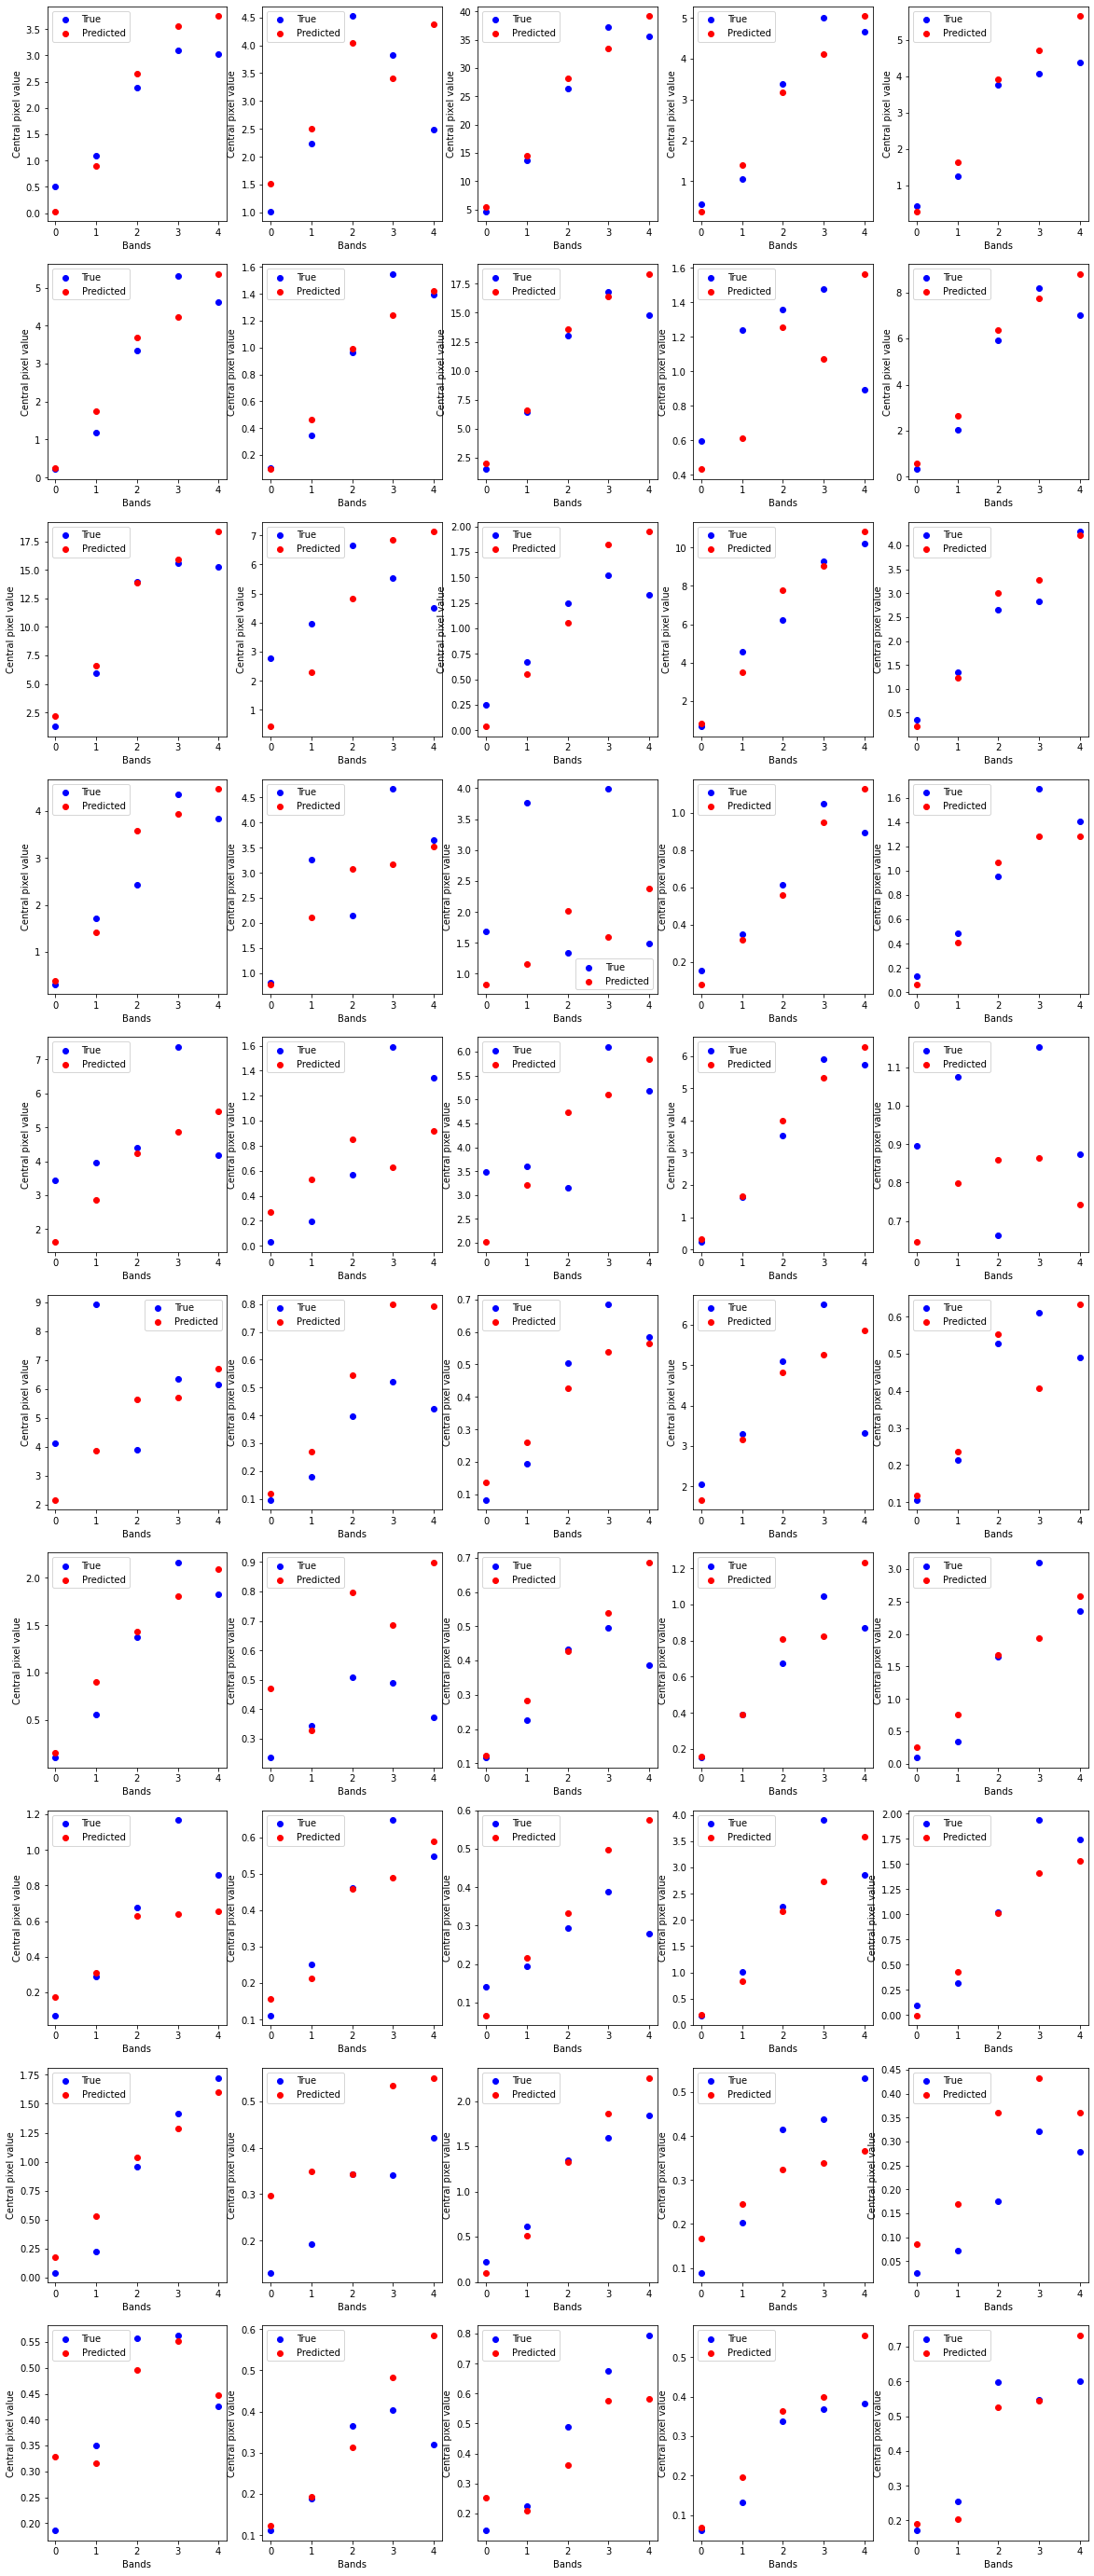

In [22]:
scatter_bands_center(50)

In [23]:
# scatter_bands_mean(10, 0)

In [24]:
# scatter_bands_percentile()

In [25]:
# display_histograms()

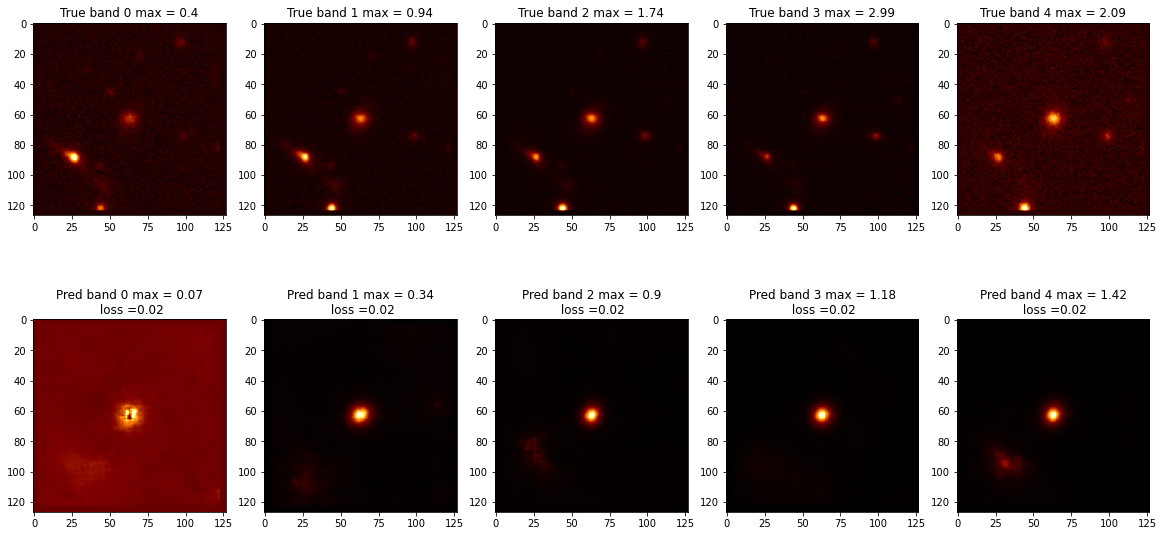

In [52]:
display_5_bands(19)

130

144

212

240

291

298

316

435

437

477



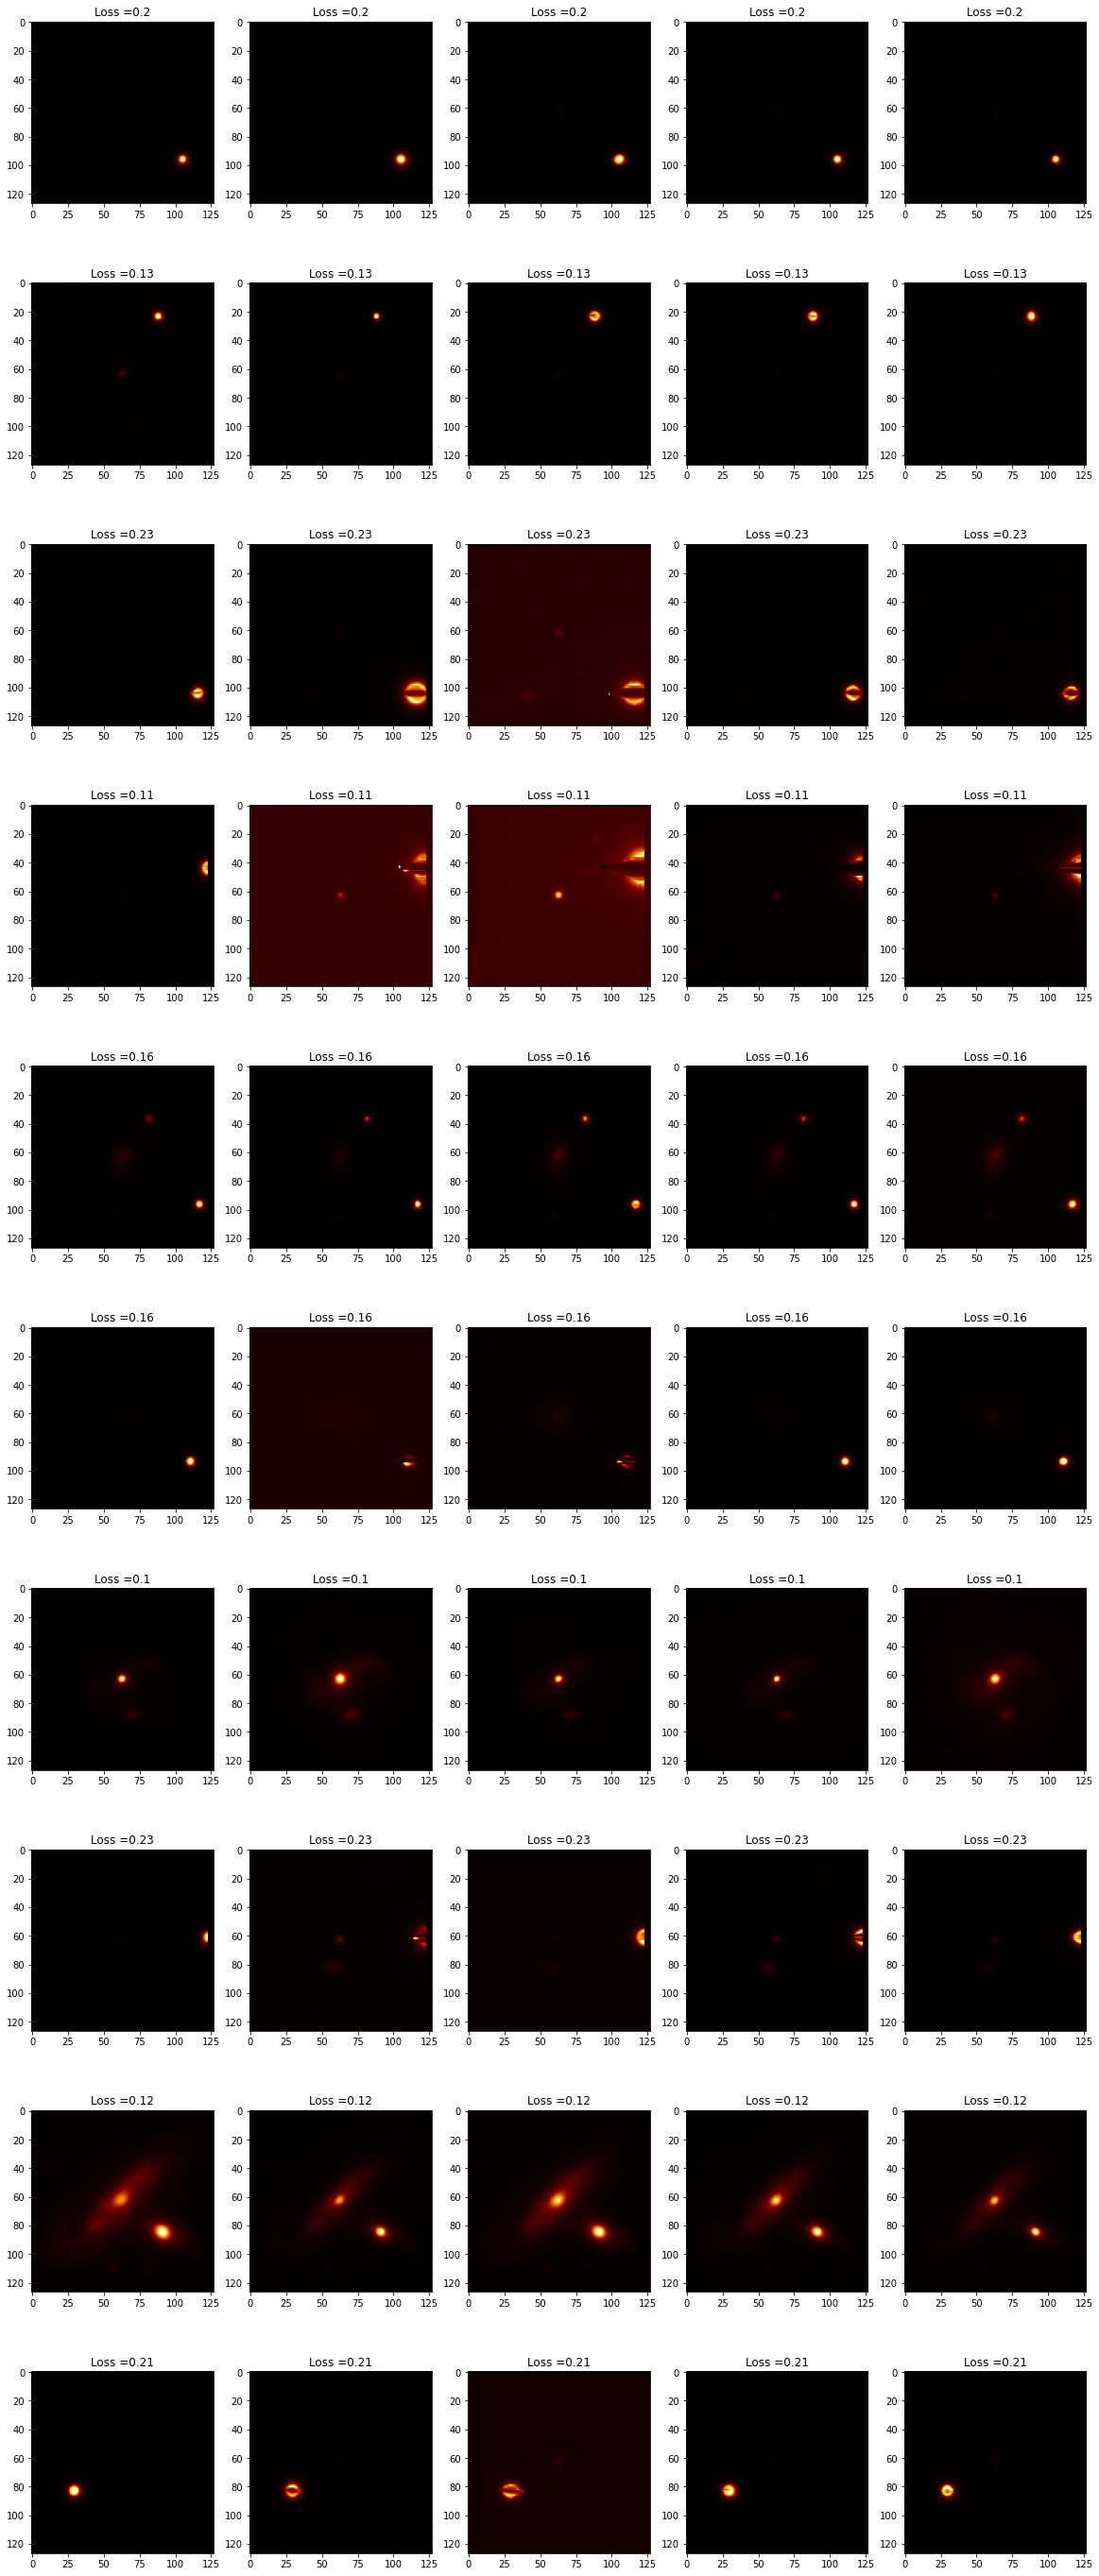

In [27]:
display_high_loss(10, 0.1)

In [28]:
hf_test = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing_small.hdf5', 'r')
x_test = np.asarray(hf_test['image'][0:])
max_value = 4.16
x_test = np.true_divide(x_test, max_value)
y_test = np.asarray(hf_test['specz_redshift'][0:])[..., None]
object_id = np.asarray(hf_test['object_id'][0:])
ra_test = np.asarray(hf_test['ra'][0:])
dec_test = np.asarray(hf_test['dec'][0:])
hf_test.close()

In [29]:
object_id[240]

39613222105413879

In [30]:
object_id[212]

38558781864440518

In [31]:
ra_test[240]

34.93271812448192

In [32]:
ra_test[212]

36.462387012951424

In [33]:
dec_test[240]

-2.151346680197777

In [34]:
dec_test[212]

-4.046503252830899

look at RA dec of these objects, see if they are already present

galaxies?
clusters in galaxies
merging galaxies
artifacts

In [35]:
loss_array = np.array([])
for i in range(len(x_test)):
    loss = model.evaluate(np.array([x_test[i]]), np.array([x_test[i]]), verbose = 0)
    loss_array = np.append(loss_array, loss)

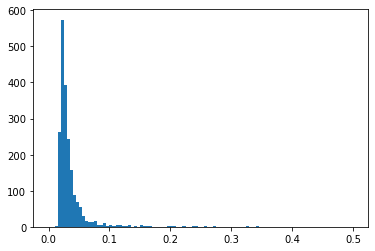

In [36]:
plt.hist(loss_array, bins = 100, range = (0, 0.5))
plt.show()

Look at the loss of those galaxies
Put data through VAE

In [37]:
def generate_example_galaxies(num_to_generate = 10):
    z = prior.sample(num_to_generate)
    xhat = model.decoder(z)
    fig, axes = plt.subplots(nrows = num_to_generate, ncols = 5, figsize = (4 * 5, 4 * num_to_generate))
    for i in range(num_to_generate):
        for j in range(0,5):
            axes[i][j].imshow(xhat[i][j], cmap = 'afmhot')
            axes[i][j].set_title(f'Generated image {i} band {j}')

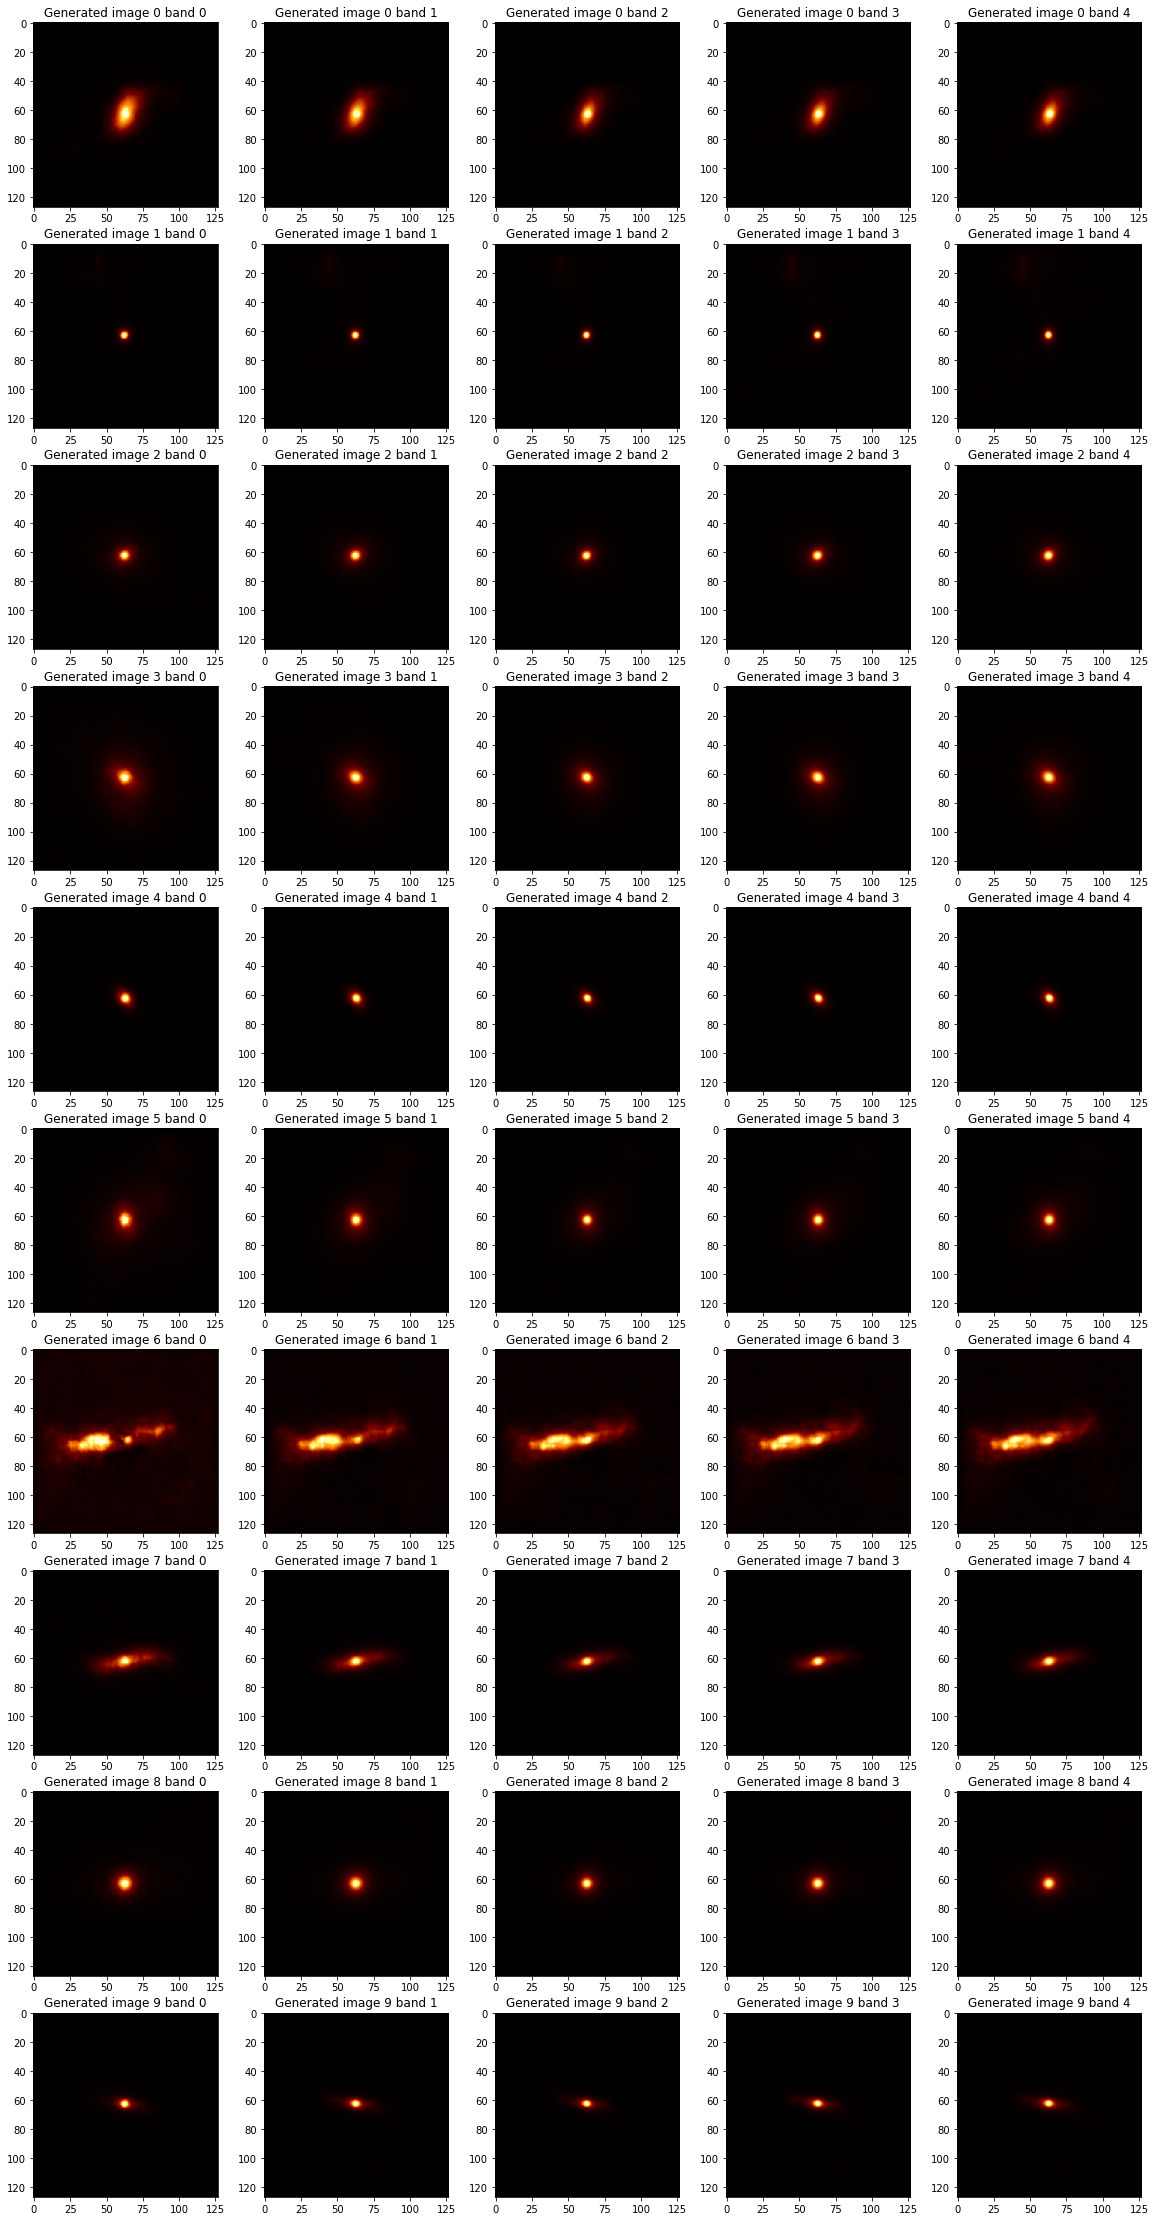

In [38]:
generate_example_galaxies(10)

In [39]:
# END